In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# !pip install xgboost

from xgboost import XGBRegressor

import pickle
import json
import os
from tqdm import tqdm

from dotenv import load_dotenv, find_dotenv
from openai import OpenAI
import openai
%matplotlib inline


filedir = os.path.join(os.path.dirname(os.getcwd()), 'Clustering and Regression')
filename = 'data.csv'

In [3]:
load_dotenv(dotenv_path = os.path.join(os.path.dirname(os.getcwd()), '.env'))


openai.api_key  = os.getenv('OPENAI_API_KEY')

client = OpenAI()

EMBED_MODEL = "text-embedding-ada-002"

df = pd.read_csv(os.path.join(filedir, filename), encoding='ISO-8859-1')
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df['Amount'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['CustomerID'] = df['CustomerID'].astype(str)

In [5]:
unique_descriptions = df['Description'].dropna().unique()

def get_embedding(text, model=EMBED_MODEL):
    try:
        response = client.embeddings.create(input=[text], model=model)
        return response.data[0].embedding
    except Exception as e:
        print(f"Error: {e}")
        return None

embedding_path = os.path.join(os.path.dirname(os.getcwd()), 'Clustering and Regression', 'data', 'desc_embeddings.json')
if os.path.exists(embedding_path):
    with open(embedding_path, "r") as f:
        desc_embeddings = json.load(f)
else:
    desc_embeddings = {}
    for desc in tqdm(unique_descriptions):
        desc_embeddings[desc] = get_embedding(desc)
    with open(embedding_path, "w") as f:
        json.dump(desc_embeddings, f)

df['desc_vector'] = df['Description'].map(desc_embeddings)
df['desc_vector'] = df['desc_vector'].apply(lambda x: np.array(x) if isinstance(x, list) else None)

user_vectors = {}
for cid, group in df.groupby('CustomerID'):
    vectors = [v for v in group['desc_vector'] if isinstance(v, np.ndarray)]
    if vectors:
        user_vectors[cid] = np.mean(vectors, axis=0)

user_df = pd.DataFrame.from_dict(user_vectors, orient='index')
user_df.columns = [f'emb_{i}' for i in range(user_df.shape[1])]
user_df['CustomerID'] = user_df.index

X = user_df[[col for col in user_df.columns if col.startswith('emb_')]]

kmeans = KMeans(n_clusters=5, random_state=42)
user_df['InterestCluster'] = kmeans.fit_predict(X)


In [8]:
NOW = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (NOW - x.max()).days,
    'InvoiceNo': 'nunique',
    'Amount': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Amount': 'Monetary'
}).reset_index()

rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

rfm['RFM_Score'] = rfm['R_score'] + rfm['F_score'] + rfm['M_score']


In [9]:
full_df = pd.merge(rfm, user_df[['CustomerID', 'InterestCluster']], on='CustomerID', how='left')

full_df = pd.get_dummies(full_df, columns=['InterestCluster'], prefix='cluster')

full_df['LTV'] = full_df['Monetary'] * full_df['Frequency']

In [10]:
features = ['Recency', 'Frequency', 'Monetary', 'RFM_Score'] + [col for col in full_df.columns if col.startswith('cluster_')]
X = full_df[features]
y = full_df['LTV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.2f}")

Test RMSE: 877819.14


In [11]:
full_df['LTV_Pred'] = model.predict(full_df[features])
full_df = full_df.sort_values(by='LTV_Pred', ascending=False)

print(full_df[['CustomerID', 'LTV_Pred']].head())


     CustomerID    LTV_Pred
1880    14911.0  28739096.0
1690    14646.0  20682402.0
4011    17841.0  20192278.0
1662    14606.0  18514730.0
3729    17450.0   8882999.0


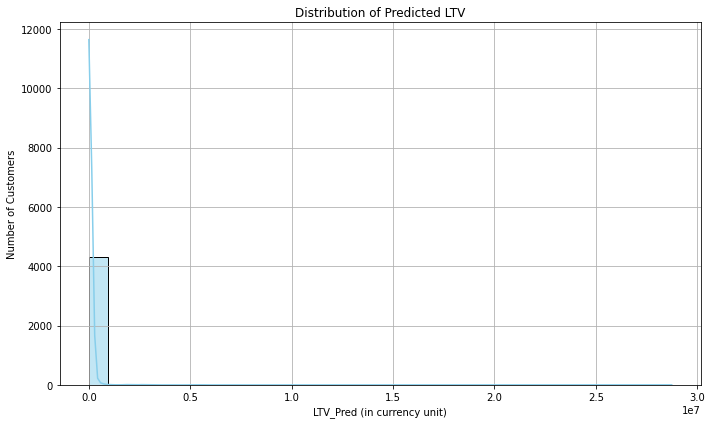

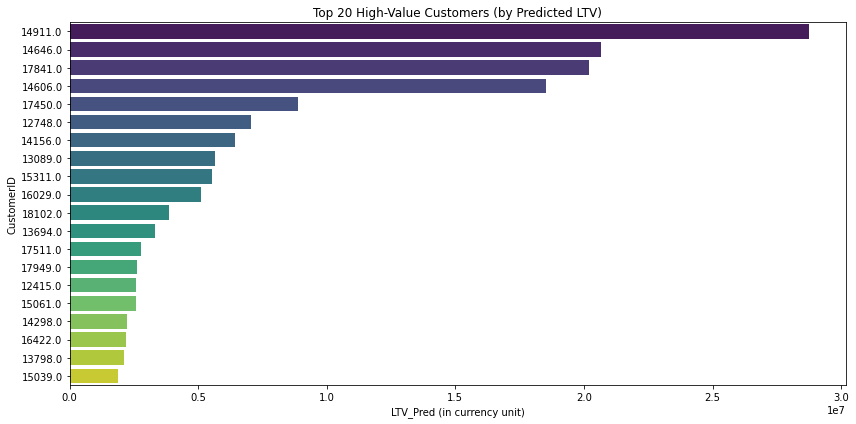

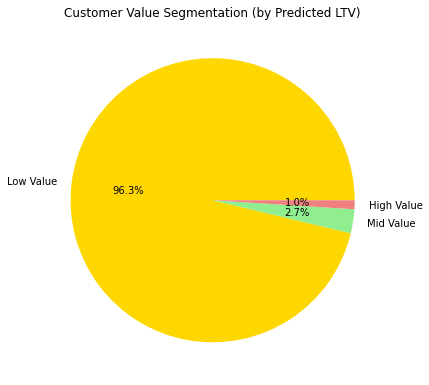

In [12]:
import matplotlib.pyplot as plt
# !pip install seaborn
import seaborn as sns

# Plot the distribution of predicted LTV values
plt.figure(figsize=(10, 6))
sns.histplot(full_df['LTV_Pred'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Predicted LTV')
plt.xlabel('LTV_Pred (in currency unit)')
plt.ylabel('Number of Customers')
plt.grid(True)
plt.tight_layout()
plt.show()

# Top 20 customers with highest predicted LTV
top_customers = full_df.sort_values(by='LTV_Pred', ascending=False).head(20)
plt.figure(figsize=(12, 6))
sns.barplot(x='LTV_Pred', y='CustomerID', data=top_customers, palette='viridis')
plt.title('Top 20 High-Value Customers (by Predicted LTV)')
plt.xlabel('LTV_Pred (in currency unit)')
plt.ylabel('CustomerID')
plt.tight_layout()
plt.show()

# Classify customers based on LTV levels
def classify_ltv(ltv):
    if ltv > 500000:
        return 'High Value'
    elif ltv > 100000:
        return 'Mid Value'
    else:
        return 'Low Value'

full_df['LTV_Level'] = full_df['LTV_Pred'].apply(classify_ltv)

# Pie chart of LTV levels
value_counts = full_df['LTV_Level'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    value_counts,
    labels=value_counts.index,
    autopct='%1.1f%%',
    colors=['gold', 'lightgreen', 'lightcoral']
)
plt.title('Customer Value Segmentation (by Predicted LTV)')
plt.tight_layout()
plt.show()
